## Machine Learning Model Building Pipeline: Data Analysis

In this following notebook, we will go through the Data Analysis step in the Machine Learning model building pipeline. There will be a notebook for each one of the Machine Learning Pipeline steps:

1. Data Analysis
2. Feature Engineering
3. Feature Selection
4. Model Building

**This is the notebook for step 1: Data Analysis**

The dataset can be found in [iNeuron](https://challenge-ineuron.in/mlchallenge.php#) ML Challenge 2.

===================================================================================================

## Predicting Rent Price of Houses

The aim of the project is to build a machine learning model to predict the rent price of homes based on different explanatory variables describing aspects of residential houses. 


### What is the objective of the machine learning model?

We aim to minimise the difference between the real rent and the rent estimated by our model. We will evaluate model performance using the mean squared error (mse) and the root squared of the mean squared error (rmse).

====================================================================================================

## House Prices dataset: Feature Engineering

In the following cells, we will engineer / pre-process the variables of the House Rent Dataset from iNeuron. We will engineer the variables so that we tackle:

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
5. Standarise the values of the variables to the same range

### Setting the seed

It is important to note that we are engineering variables and pre-processing data with the idea of deploying the model. Therefore, from now on, for each step that includes some element of randomness, it is extremely important that we **set the seed**. This way, we can obtain reproducibility between our research and our development code.


Let's go ahead and load the dataset.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv('../dataset/housing_train.csv')
data.shape

(265190, 22)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
id                         265190 non-null int64
url                        265190 non-null object
region                     265190 non-null object
region_url                 265190 non-null object
price                      265190 non-null int64
type                       265190 non-null object
sqfeet                     265190 non-null int64
beds                       265190 non-null int64
baths                      265190 non-null float64
cats_allowed               265190 non-null int64
dogs_allowed               265190 non-null int64
smoking_allowed            265190 non-null int64
wheelchair_access          265190 non-null int64
electric_vehicle_charge    265190 non-null int64
comes_furnished            265190 non-null int64
laundry_options            210879 non-null object
parking_options            170055 non-null object
image_url                  265190 non-null objec

## Data Cleaning

Getting appropriate data types. For example baths have a dtype of float, and it contains some decimal values. But it is a quantitative variable. So transforming it to remove decimal.

In [4]:
data['baths'] = np.ceil(data['baths'])
data['baths'] = data['baths'].astype(np.int)

## Missing values

### Categorical variables

In [5]:
# make a list of the categorical variables that contain missing values
cat_var_na = ['laundry_options', 'parking_options']

In [6]:
def impute_missing_cat(data, var, modeof):
    return data.groupby(modeof)[var].transform(
        lambda x: x.fillna(x.mode()[0]))

In [7]:
data["laundry_options"] = impute_missing_cat(data, "laundry_options", "type")
data["parking_options"] = impute_missing_cat(data, "parking_options", "type")
data = data.dropna(subset=["state", "description"],axis=0)

### Numerical variables


In [8]:
# make a list with the numerical variables that contain missing values
num_var_na = ['lat', 'long']

In [9]:
def impute_missing_num(data, var, meanof):
    return data.groupby(meanof)[var].transform(
        lambda x: x.fillna(x.mode()[0]))

In [10]:
data["lat"] = impute_missing_num(data, "lat", "region")
data["long"] = impute_missing_num(data, "long", "region")

Is there any remaining missing value ? 

In [11]:
#Check remaining missing values if any 
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [12]:
data.shape

(265187, 22)

## Outliers

In EDA, we decided to remove outliers according to the upper and lower bound of its interquartile range.

In [13]:
price_upper, price_lower = 2400, 1
sqfeet_upper, sqfeet_lower = 1762, 1
beds_upper, beds_lower = 3, 1
baths_upper, baths_lower = 3, 1

data = data[(data['price'] <= price_upper) & (data['price'] >= price_lower)]
data = data[(data['sqfeet'] <= sqfeet_upper) & (data['sqfeet'] >= sqfeet_lower)]
data = data[(data['beds'] <= beds_upper) & (data['beds'] >= beds_lower)]
data = data[(data['baths'] <= baths_upper) & (data['baths'] >= baths_lower)]

In [14]:
data.shape

(229505, 22)

## Getting More Features

In [15]:
data['premium_house'] = np.where((data['baths']>=data['beds'])&(data['beds']>1),1,0)
data['pets_allowed'] = np.where((data['cats_allowed']==1)&data['dogs_allowed']==1,1,0)
data['beds_per_sqfeet'] = data['beds'] / data['sqfeet']
data['baths_per_beds'] = data['baths'] / data['beds']

## Exploring *'description'* column

In [16]:
data.description[82226].lower()

'live on a pet ranch loft apt $550 per month includes electric and water pets ok includes your horse 40 acre pasture and stalls please pet lover only  contact bill bell  show contact info  for more details great for single horse lover  f/l/s discount rate for ranch help'

In [17]:
[x in data.description[82226].lower() for x in ['pool', 'swimming','wi-fi','fireplace','grilling','gym','fence', 'court']]

[False, False, False, False, False, False, False, False]

Let's get some intriguing new features

In [18]:
data['has_pool'] = data['description'].apply(lambda x: 1 if 'pool' in x.lower() or 'swimming' in x.lower() else 0)
data['has_grill'] = data['description'].apply(lambda x: 1 if 'grill' in x.lower() or 'grilling' in x.lower() else 0)
data['has_fireplace'] = data['description'].apply(lambda x: 1 if 'fireplace' in x.lower() or 'fire pits' in x.lower() else 0)
data['gym_nearby'] = data['description'].apply(lambda x: 1 if 'gym' in x.lower() or 'fitness' in x.lower() else 0)
data['school/clg_nearby'] = data['description'].apply(lambda x: 1 if 'school' in x.lower() or 'college' in x.lower() else 0)
data['wifi_facilities'] = data['description'].apply(lambda x: 1 if 'wifi' in x.lower() or 'wi-fi' in x.lower() else 0)
data['valet_service'] = data['description'].apply(lambda x: 1 if 'valet' in x.lower() else 0)
data['shopping_nearby'] = data['description'].apply(lambda x: 1 if 'shopping' in x.lower() else 0)
data['sports_playground'] = data['description'].apply(lambda x: 1 if 'sport' in x.lower()  or 'sports' in x.lower() 
                                                      or 'tennis' in x.lower() or 'soccer' in x.lower() 
                                                      or 'soccers' in x.lower() or 'court' in x.lower() else 0)
data['dining_nearby'] = data['description'].apply(lambda x: 1 if 'dining' in x.lower() else 0)


In [19]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state', 'premium_house', 'pets_allowed', 'beds_per_sqfeet',
       'baths_per_beds', 'has_pool', 'has_grill', 'has_fireplace',
       'gym_nearby', 'school/clg_nearby', 'wifi_facilities', 'valet_service',
       'shopping_nearby', 'sports_playground', 'dining_nearby'],
      dtype='object')

In [20]:
for var in ['has_pool', 'has_grill', 'has_fireplace', 'gym_nearby',
       'school/clg_nearby', 'wifi_facilities', 'valet_service',
       'shopping_nearby', 'sports_playground', 'dining_nearby']:
    print(data[var].value_counts())

1    121497
0    108008
Name: has_pool, dtype: int64
0    194291
1     35214
Name: has_grill, dtype: int64
0    197392
1     32113
Name: has_fireplace, dtype: int64
0    132430
1     97075
Name: gym_nearby, dtype: int64
0    190911
1     38594
Name: school/clg_nearby, dtype: int64
0    200977
1     28528
Name: wifi_facilities, dtype: int64
0    224254
1      5251
Name: valet_service, dtype: int64
0    154974
1     74531
Name: shopping_nearby, dtype: int64
0    155299
1     74206
Name: sports_playground, dtype: int64
0    173014
1     56491
Name: dining_nearby, dtype: int64


## Numerical variable transformation

We will log transform the positive numerical variables in order to get a more Gaussian-like distribution. This tends to help Linear machine learning models. 

In [21]:
for var in ['price','sqfeet','baths_per_beds','beds_per_sqfeet']:
    data[var] = np.log(data[var])

In [22]:
# check that data set does not contain null values in the engineered variables
[var for var in ['price','sqfeet','baths_per_beds','beds_per_sqfeet'] if data[var].isnull().sum() > 0]

[]

## Categorical variables

### Removing rare labels

First, we will group those categories within variables that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, well be replaced by the string "Rare".

To learn more about how to handle categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/feature-engineering-for-machine-learning/?couponCode=UDEMY2018) in Udemy.

In [23]:
# let's capture the categorical variables in a list

cat_vars = ['region', 'type', 'laundry_options', 'parking_options', 'state']

In [24]:
frequent_ls = {
    'region': 
        ['denver', 'fayetteville', 'jacksonville', 'omaha / council bluffs', 'rochester'],
     'type': 
        ['apartment', 'condo', 'duplex', 'house', 'manufactured', 'townhouse'],
     'laundry_options': 
        ['laundry in bldg', 'laundry on site', 'w/d hookups', 'w/d in unit'],  
     'parking_options': 
        ['attached garage', 'carport', 'detached garage', 'off-street parking', 'street parking'],
     'state': 
        ['al', 'ar', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 
        'ma', 'md', 'mi', 'mn', 'ms', 'nc', 'nd', 'ne', 'nj', 'nm', 'nv', 'ny', 'oh']
}


for var in cat_vars:
    data[var] = np.where(data[var].isin(
        frequent_ls[var]), data[var], 'Rare')

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target.

To learn more about how to encode categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/feature-engineering-for-machine-learning/?couponCode=UDEMY2018) in Udemy.

In [25]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(data, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = data.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [26]:
for var in cat_vars:
    replace_categories(data, var, 'price')

In [27]:
# check absence of na in the train set
[var for var in data.columns if data[var].isnull().sum() > 0]

[]

In [28]:
data.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,premium_house,pets_allowed,beds_per_sqfeet,baths_per_beds,has_pool,has_grill,has_fireplace,gym_nearby,school/clg_nearby,wifi_facilities,valet_service,shopping_nearby,sports_playground,dining_nearby
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,3,https://bham.craigslist.org,7.021084,3,7.184629,3,2,1,1,1,0,0,0,1,0,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,7,0,1,-6.086017,-0.405465,0,0,0,0,1,0,0,1,0,0
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,3,https://bham.craigslist.org,6.715383,3,7.032624,1,2,1,1,1,0,0,0,1,1,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,7,0,1,-7.032624,0.693147,1,1,1,1,1,0,1,1,1,1
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,3,https://bham.craigslist.org,6.684612,3,6.831954,1,1,1,1,1,0,0,0,1,1,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,7,0,1,-6.831954,0.000000,1,1,1,1,1,0,1,1,1,1
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,3,https://bham.craigslist.org,6.665684,3,6.953684,2,1,1,1,1,0,0,0,1,1,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,7,0,1,-6.260537,-0.693147,1,1,1,1,1,0,1,1,1,1
5,7041966868,https://bham.craigslist.org/apa/d/birmingham-s...,3,https://bham.craigslist.org,6.802395,3,7.168580,2,2,1,1,1,0,0,0,1,1,https://images.craigslist.org/00606_g79izH5xxk...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,7,1,1,-6.475433,0.000000,1,1,1,0,1,0,1,1,1,1


In [29]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state', 'premium_house', 'pets_allowed', 'beds_per_sqfeet',
       'baths_per_beds', 'has_pool', 'has_grill', 'has_fireplace',
       'gym_nearby', 'school/clg_nearby', 'wifi_facilities', 'valet_service',
       'shopping_nearby', 'sports_playground', 'dining_nearby'],
      dtype='object')

In [30]:
features = ['region', 'price', 'type', 'sqfeet', 'smoking_allowed', 'wheelchair_access', 
            'electric_vehicle_charge', 'comes_furnished', 'laundry_options', 'parking_options','lat', 'long', 
            'premium_house', 'pets_allowed', 'beds_per_sqfeet', 'baths_per_beds', 'has_pool', 'has_grill', 
            'has_fireplace', 'gym_nearby', 'school/clg_nearby', 'wifi_facilities', 'valet_service', 
            'shopping_nearby', 'sports_playground', 'dining_nearby']

data_final = data[features].copy()
data_final.head()

,region,price,type,sqfeet,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,premium_house,pets_allowed,beds_per_sqfeet,baths_per_beds,has_pool,has_grill,has_fireplace,gym_nearby,school/clg_nearby,wifi_facilities,valet_service,shopping_nearby,sports_playground,dining_nearby
1,3,7.021084,3,7.184629,1,0,0,0,1,0,33.3755,-86.8045,0,1,-6.086017,-0.405465,0,0,0,0,1,0,0,1,0,0
2,3,6.715383,3,7.032624,1,0,0,0,1,1,33.4226,-86.7065,0,1,-7.032624,0.693147,1,1,1,1,1,0,1,1,1,1
3,3,6.684612,3,6.831954,1,0,0,0,1,1,33.4226,-86.7065,0,1,-6.831954,0.000000,1,1,1,1,1,0,1,1,1,1
4,3,6.665684,3,6.953684,1,0,0,0,1,1,33.4226,-86.7065,0,1,-6.260537,-0.693147,1,1,1,1,1,0,1,1,1,1
5,3,6.802395,3,7.168580,1,0,0,0,1,1,33.4226,-86.7065,1,1,-6.475433,0.000000,1,1,1,0,1,0,1,1,1,1


In [31]:
for feature in features:
    data_final[feature] = data_final[feature].astype(np.float64)

### Correlation Heatmap

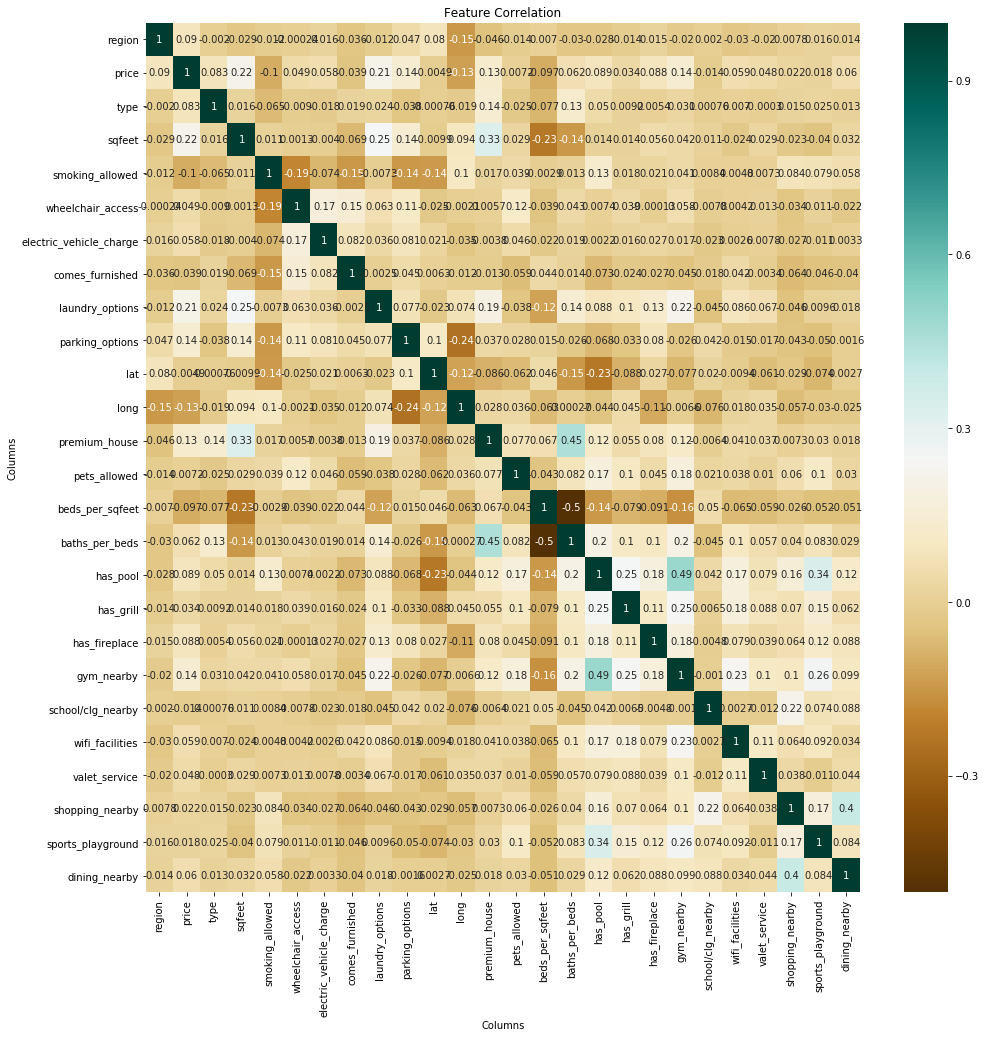

In [32]:
fig, ax = plt.subplots(figsize=(16,16)) 
sns.heatmap(data_final.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

In [33]:
data_final.to_csv('data_cleaned.csv', index=False)